In [1]:
from pandas_datareader import data, wb
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
Amazon = data.DataReader("AMZN", data_source="yahoo", start = "1997-05-01", end = "2019-06-01")
Amazon.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1997-05-15,2.500000,1.927083,2.437500,1.958333,72156000.0,1.958333
1997-05-16,1.979167,1.708333,1.968750,1.729167,14700000.0,1.729167
1997-05-19,1.770833,1.625000,1.760417,1.708333,6106800.0,1.708333
1997-05-20,1.750000,1.635417,1.729167,1.635417,5467200.0,1.635417
1997-05-21,1.645833,1.375000,1.635417,1.427083,18853200.0,1.427083


In [3]:
Amazon.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-05-20,1867.780029,1835.540039,1852.689941,1858.969971,3798200.0,1858.969971
2019-05-21,1879.000000,1846.000000,1874.790039,1857.520020,4005100.0,1857.520020
2019-05-22,1871.489990,1851.000000,1851.780029,1859.680054,2936600.0,1859.680054
2019-05-23,1844.000000,1804.199951,1836.589966,1815.479980,4424300.0,1815.479980
2019-05-24,1841.760010,1817.849976,1835.890015,1823.280029,3366700.0,1823.280029


In [4]:
Amazon.shape

(5543, 6)

In [5]:
Amazon_train = Amazon.iloc[:5400, :]
Amazon_train.shape

(5400, 6)

In [6]:
Amazon_test = Amazon.iloc[5400:, :]
Amazon_test.shape

(143, 6)

In [7]:
training_set = Amazon.iloc[:5400, 2:3].values
training_set

array([[2.43750000e+00],
       [1.96875000e+00],
       [1.76041663e+00],
       ...,
       [1.77369995e+03],
       [1.70333997e+03],
       [1.64958997e+03]])

In [8]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, 5399):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [9]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


# Fitting the RNN to the Training set 
history = regressor.fit(X_train, y_train, shuffle=True, epochs = 50, batch_size = 32)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
5339/5339 [==============================] - 96s 18ms/step - loss: 0.0038
Epoch 2/50
5339/5339 [==============================] - 85s 16ms/step - loss: 7.0795e-04
Epoch 3/50
5339/5339 [==============================] - 82s 15ms/step - loss: 7.1536e-04
Epoch 4/50
5339/5339 [==============================] - 82s 15ms/step - loss: 5.6853e-04
Epoch 5/50
5339/5339 [==============================] - 80s 15ms/step - loss: 5.9119e-04
Epoch 6/50
5339/5339 [==============================] - 80s 15ms/step - loss: 6.5078e-04
Epoch 7/50
5339/5339 [==============================] - 80s 15ms/step - loss: 5.3652e-04
Epoch 8/50
5339/5339 [==============================] - 81s 15ms/step - loss: 5.0622e-04
Epoch 9/50
5339/5339 [==============================] - 8

In [10]:
# Part 3 - Making the predictions and visualising the results

# Getting the real recent stock price until May 2019
real_stock_price = Amazon_test.iloc[:, 2:3].values

In [11]:
# Getting the predicted stock price until May 2019
Amazon_total = pd.concat((Amazon_train['Close'], Amazon_test['Close']), axis = 0)
inputs = Amazon_total[len(Amazon_total) - len(Amazon_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 203):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

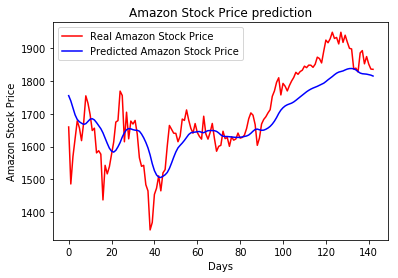

In [12]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Amazon Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Amazon Stock Price')
plt.title('Amazon Stock Price prediction')
plt.xlabel('Days')
plt.ylabel('Amazon Stock Price')
plt.legend()
plt.show()

In [13]:
#Evaluating the RNN
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
rmse

75.31616040084785

In [14]:
min_val=min(real_stock_price)
max_val=max(real_stock_price)
print ("relative error: ", rmse/(max_val-min_val))

relative error:  [0.12490242]


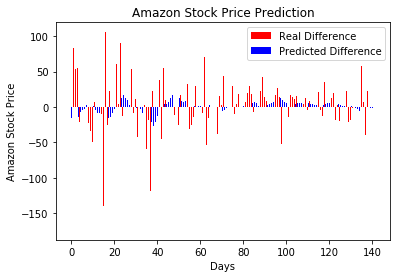

In [15]:
# Visualising the results
 
shift_pred= predicted_stock_price[:-1]
shift_pred = np.append(0, np.reshape(shift_pred, len(shift_pred)))
shift_real = real_stock_price[:-1]
shift_real = np.append(0, np.reshape(shift_real, len(shift_real)))
 
dif_pred = np.add(np.reshape(predicted_stock_price, len(predicted_stock_price)), - shift_pred)[1:]
dif_real = np.add(np.reshape(real_stock_price, len(real_stock_price)), - shift_real)[1:]
 
fig, ax = plt.subplots()
ind = np.arange(dif_real.size)
real_bar = ax.bar(ind-0.15, dif_real, width=0.3, color = 'red', label = 'Real Difference')
pred_bar = ax.bar(ind+0.15, dif_pred, width=0.3, color = 'blue', label = 'Predicted Difference')
ax.set_title('Amazon Stock Price Prediction')
ax.set_xlabel('Days')
ax.set_ylabel('Amazon Stock Price')
ax.legend()
plt.show()